In [109]:
import numpy as np
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt

In [110]:
# Import necessary libraries to do ML

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_squared_log_error, explained_variance_score

In [111]:
# Connection String

serverName = "sqlserver-pw.database.windows.net" 
databaseName = "db-ai"
username = "girls"
password = "Password?"

In [114]:
# Make the conncection to our Server

cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+serverName+';DATABASE='+databaseName+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [115]:
#Splitting the Dataset based on the value of BEP

query_1 = "SELECT  Canale, CodAgenzia,ClusterAgenzia, CodContratto,CategoriaCespite, Cespite, TipologiaUtenza,[DataTrasf.entr.], Anagrafica,SettoreMerceologico, ListinoProposto, [Soc.Vend.Prec.],ClusterSocVend,Localita, [Cod.ISTAT], Provincia,RegioneItaliana, Zona, ModoPagamento, RedditoTotale, Mese01,MesiBEP,MesiAttivi, UltimoReddito FROM try.DatiConsumi_ML WHERE [Soc.Vend.Prec.] is not null and BEP = 1"
query_0 = "SELECT  Canale, CodAgenzia,ClusterAgenzia, CodContratto,CategoriaCespite, Cespite, TipologiaUtenza,[DataTrasf.entr.], Anagrafica,SettoreMerceologico, ListinoProposto, [Soc.Vend.Prec.],ClusterSocVend,Localita, [Cod.ISTAT], Provincia,RegioneItaliana, Zona, ModoPagamento, RedditoTotale, Mese01,MesiBEP,MesiAttivi, UltimoReddito FROM try.DatiConsumi_ML WHERE [Soc.Vend.Prec.] is not null and BEP = 0"


In [116]:
#Load the dataset into a pandas DataFrame

df_1 = pd.read_sql(query_1, cnxn)

df_0 = pd.read_sql(query_0, cnxn)

C:\Users\IreneDeNevi\AppData\Local\Temp\ipykernel_7688\2517276147.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_1 = pd.read_sql(query_1, cnxn)
C:\Users\IreneDeNevi\AppData\Local\Temp\ipykernel_7688\2517276147.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_0 = pd.read_sql(query_0, cnxn)


Error: ('01000', '[01000] [Microsoft][ODBC SQL Server Driver][DBNETLIB]ConnectionWrite (send()). (10054) (SQLGetData); [01000] [Microsoft][ODBC SQL Server Driver][DBNETLIB]General network error. Check your network documentation. (11)')

In [ ]:
df_1['Year_Trasf.entr.'] = pd.to_datetime(df_1['DataTrasf.entr.']).dt.year
df_1['Month_Trasf.entr.'] = pd.to_datetime(df_1['DataTrasf.entr.']).dt.month
df_1['Day_Trasf.entr.'] = pd.to_datetime(df_1['DataTrasf.entr.']).dt.day
df_1.drop(['DataTrasf.entr.'],axis=1,inplace=True) 

In [ ]:
df_0['Year_Trasf.entr.'] = pd.to_datetime(df_0['DataTrasf.entr.']).dt.year
df_0['Month_Trasf.entr.'] = pd.to_datetime(df_0['DataTrasf.entr.']).dt.month
df_0['Day_Trasf.entr.'] = pd.to_datetime(df_0['DataTrasf.entr.']).dt.day
df_0.drop(['DataTrasf.entr.'],axis=1,inplace=True) 

Machine Learning BEP 1

In [ ]:
# Define and fit models
models = {
    'LinearRegression' : LinearRegression(),
    'GradientBoostingRegressor' : GradientBoostingRegressor(),
    'Lasso' :   Lasso(alpha=0.2),
    'KNeighborsRegressor': KNeighborsRegressor(algorithm='auto')
}

KeyboardInterrupt: 

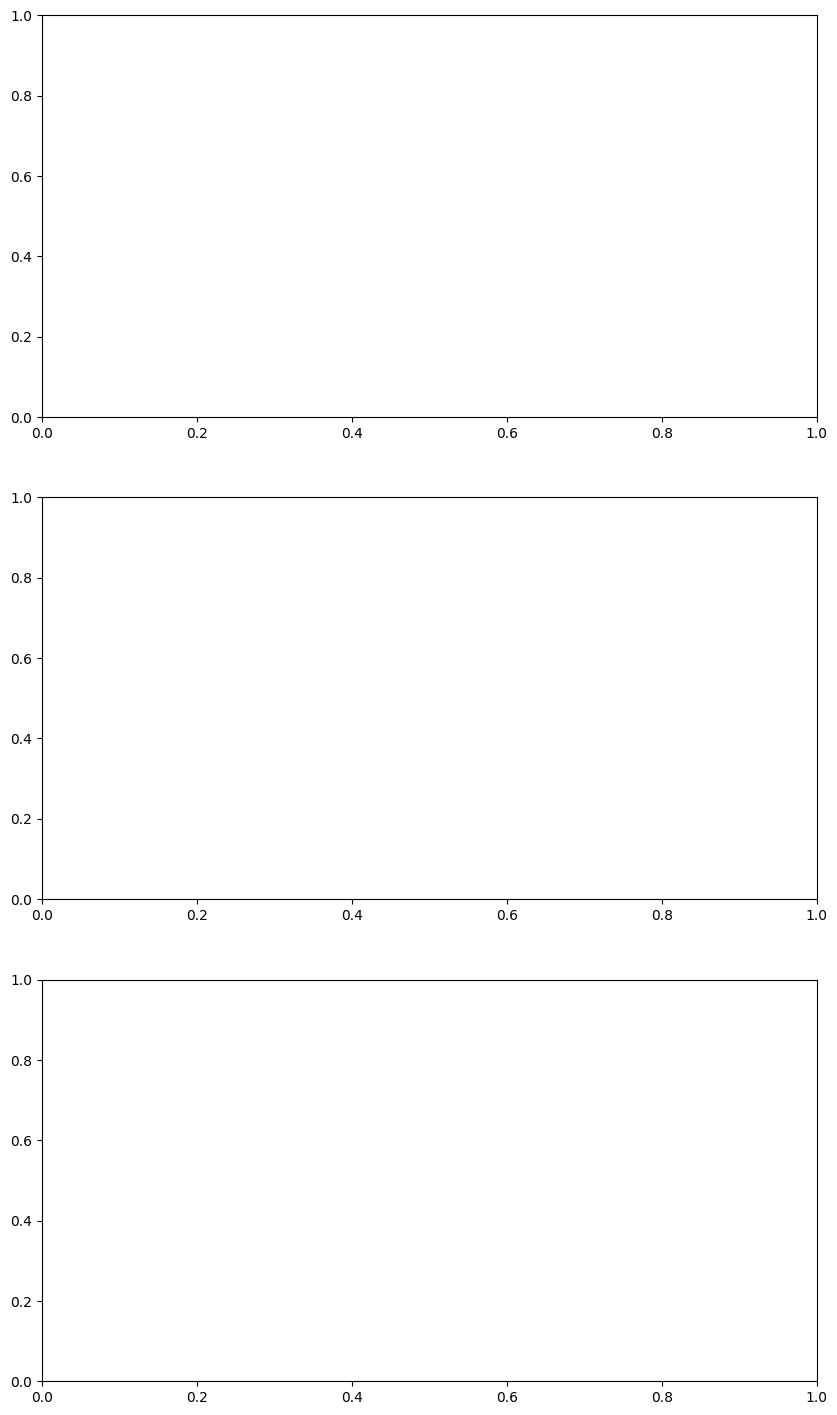

In [ ]:
# Lista dei target
targets = ['MesiAttivi', 'UltimoReddito', 'MesiBEP']  # Target

# Loop sui target
for target in targets:
    # Seleziona il target corrente
    y_1 = df_1[target]
    
    # Seleziona le features escludendo il target corrente
    features_to_exclude = [target]
    X_1 = df_1.drop(features_to_exclude, axis=1)
    
    # Splitta il dataset in training e testing set
    X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
    
    # Esegui eventuali operazioni di pre-processing

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define a list of tuples for VotingRegressor
    estimators = list(models.items())

    # Create the VotingRegressor
    ereg = VotingRegressor(estimators)

    # Lists to store predictions for each model
    pred_individual_models = []

     # Create subplots
    fig, axes = plt.subplots(nrows=len(models), figsize=(10, 6 * (len(models) )))

    for i,(name,model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Valutation
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        msle = mean_squared_log_error(y_test, y_pred)
        explained_variance = explained_variance_score(y_test, y_pred) #Values range from 0 to 1, where 1 indicates perfect prediction.
        max_error = max_error(y_test, y_pred)

  
        print(f"{target} - {name} Mean Squared Error: {mse}")
        print(f"{target} - {name} R2 score: {r2}")
        print(f"{target} - {name} Mean Squared Logarithmic Error: {msle}")
        print(f"{target} - {name} Explained Variance Score: {explained_variance}")
        print(f"{target} - {name} Max Error: {max_error}")


        # Append predictions for individual models
        pred_individual_models.append(y_pred)

        # Plot predictions for each model, taking every 250th value
        axes[i].plot(range(0, len(y_test), 250), y_pred[::250], label=f"{name} Prediction")
        axes[i].set_ylabel("Predicted")
        axes[i].set_xlabel("Training Samples (every 250th)")
        axes[i].legend(loc="best")
        axes[i].set_title(f"{name} - Target: {target}")

    # Fit the ensemble model outside the inner loop
    ereg.fit(X_train, y_train)

    # Get predictions for the ensemble model
    y_pred_ensemble = ereg.predict(X_test)

    # Plot predictions for the VotingRegressor on each subplot
    for i in range(len(models)):
        axes[i].plot(range(0, len(y_test), 250), y_pred_ensemble[::250], 'r*', ms=10, label="VotingRegressor Prediction")
        axes[i].legend(loc="best")
    
    plt.tight_layout()
    plt.show()


